origin: http://pytorch.org/tutorials/beginner/pytorch_with_examples.html  
translator: Hongpu Liu

In [1]:
%matplotlib inline
from __future__ import print_function

# 定义新的autograd函数
每一个原生的autograd运算，都包含两个操作张量的函数。**forward**函数根据输入的张量计算输出的张量。**backward**接收某个标量值（loss）关于输出张量的梯度，然后计算该标量值关于输入张量的梯度。

在PyTorch中，可以通过继承**torch.autograd.Function**并实现**forward**和**backward**函数来自定义自动求导运算。然后用自定义的自动求导运算构建实例，该实例可以像调用函数一样，给他传递封装了输入数据的变量。

下面将用自定义的自动求导运算来执行ReLU运算，并用它实现两层的网络：

In [2]:
import torch
from torch.autograd import Variable

class MyReLU(torch.autograd.Function):
    """
    可以通过继承torch.autograd.Function来定制自动求导函数，该函数需要实现
    操作张量的前向和反向传播过程。
    """
    
    @staticmethod
    def forward(ctx, input):
        """
        在前向传播中，该函数接收一个包含输入的张量，返回一个包含输出数据的张量。
        ctx是一个上下文对象，可以用来保存供反向传播计算的信息。可以使用
        ctx.save_for_backward方法来缓存反向传播过程会使用的任意对象。
        """
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    
    @staticmethod
    def backward(ctx, grad_output):
        """
        在反向传播中，该函数接收一个包含输出张量梯度的张量，
        然后计算关于输入张量的梯度。
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input
    
dtype = torch.FloatTensor
# 若需要运行在GPU上则取消下一行的注释
# dtype = torch.cuda.FloatTensor

# N     ：样本的数量，本例采用批量梯度下降，每次训练使用全部的样本
# D_in  ：输入特征的维度
# H     ：隐层神经元的数量
# D_out ：输出层维度
N, D_in, H, D_out = 64, 1000, 100, 10

# 创建保存输入和输出的随机张量，并将张量封装到Variable当中
# 设置 requires_grad=Flase 意味着在反向传播的过程中，不需要计算关于x和y的梯度
x = Variable(torch.randn(N, D_in).type(dtype), requires_grad=False)
y = Variable(torch.randn(N, D_out).type(dtype), requires_grad=False)

# 创建存储权重的随机张量，并将它们封装到Variable当中
# 设置 requires_grad=True，意味着在反向传播的过程中，需要计算关于w1和w2的梯度
w1 = Variable(torch.randn(D_in, H).type(dtype), requires_grad=True)
w2 = Variable(torch.randn(H, D_out).type(dtype), requires_grad=True)

# 设置学习率
learning_rate = 1e-6

# 存储训练过程的loss
losses = []

for t in range(500):
    # 要使用自定义函数，需要使用Function.apply方法，首先为其定义别名‘relu’
    relu = MyReLU.apply
    
    # 前向传播：用Variable的运算计算y的预测值。
    # 用自定义的自动求导运算计算ReLU
    y_pred = relu(x.mm(w1)).mm(w2)
    
    # 计算、打印loss并存储用来绘图
    loss = (y_pred - y).pow(2).sum()
    print(t, loss.data[0])
    losses.append(loss.data[0])
    
    # 用自动求导功能进行反向传播
    loss.backward()
    
    # 用梯度下降算法更新权重
    w1.data -= learning_rate * w1.grad.data
    w2.data -= learning_rate * w2.grad.data
    
    # 更新权重后将梯度缓存手动清零
    w1.grad.data.zero_()
    w2.grad.data.zero_()

0 36531968.0
1 37050476.0
2 37499180.0
3 32104364.0
4 21968362.0
5 12124306.0
6 6118428.0
7 3240669.75
8 1978411.75
9 1389141.375
10 1072052.25
11 871360.6875
12 727818.0
13 616907.8125
14 527728.625
15 454381.09375
16 393610.28125
17 342774.03125
18 299805.28125
19 263246.96875
20 231948.046875
21 205050.21875
22 181849.703125
23 161782.625
24 144345.5
25 129130.273438
26 115796.390625
27 104067.335938
28 93726.4140625
29 84579.859375
30 76478.109375
31 69282.1640625
32 62874.1132812
33 57155.5742188
34 52045.7382812
35 47465.828125
36 43357.640625
37 39662.8398438
38 36332.53125
39 33326.4882812
40 30608.15625
41 28147.8632812
42 25916.9199219
43 23889.7558594
44 22044.0683594
45 20362.9316406
46 18830.9941406
47 17431.4277344
48 16152.8027344
49 14981.9951172
50 13907.578125
51 12922.5751953
52 12017.5849609
53 11186.0390625
54 10420.8017578
55 9715.84179688
56 9065.69824219
57 8465.23144531
58 7910.20849609
59 7396.71923828
60 6921.23632812
61 6480.7265625
62 6072.95410156
63 5694.

499 0.000575518759433


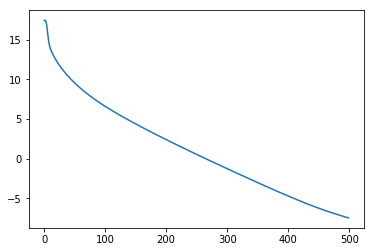

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.log(np.array(losses)))